In [4]:
import warnings
import os
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings("ignore")


In [5]:
# # 데이터셋 로드
# (raw_train, raw_validation, raw_test), metadata = tfds.load(
#     name='tf_flowers',
#     split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
#     with_info=True,
#     as_supervised=True
# )


# 데이터 저장 경로 설정
base_dir = '~/aiffel/workplace/AIFFEL_quest_cr/Exploration/Sub QUEST C 22/tf_flowers'
data_dir = os.path.join(base_dir, 'tensorflow_datasets')

# 필요한 디렉토리 생성
os.makedirs(data_dir, exist_ok=True)

# 데이터셋의 존재 여부를 확인
dataset_check_path = os.path.join(data_dir, 'tf_flowers')

if os.path.exists(dataset_check_path):
    print(f"데이터셋이 이미 존재합니다: {dataset_check_path}")
    # 이미 존재하는 데이터셋 로드
    (raw_train, raw_validation, raw_test), metadata = tfds.load(
        name='tf_flowers',
        split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
        data_dir=data_dir,
        with_info=True,
        as_supervised=True
    )
else:
    # TensorFlow Datasets를 사용하여 데이터 다운로드
    (raw_train, raw_validation, raw_test), metadata = tfds.load(
        name='tf_flowers',
        split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
        data_dir=data_dir,
        with_info=True,
        as_supervised=True
    )
    print(f"데이터는 다음 위치에 저장되었습니다.: {data_dir}")

데이터는 다음 위치에 저장되었습니다.: ~/aiffel/workplace/AIFFEL_quest_cr/Exploration/Sub QUEST C 22/tf_flowers/tensorflow_datasets


In [6]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


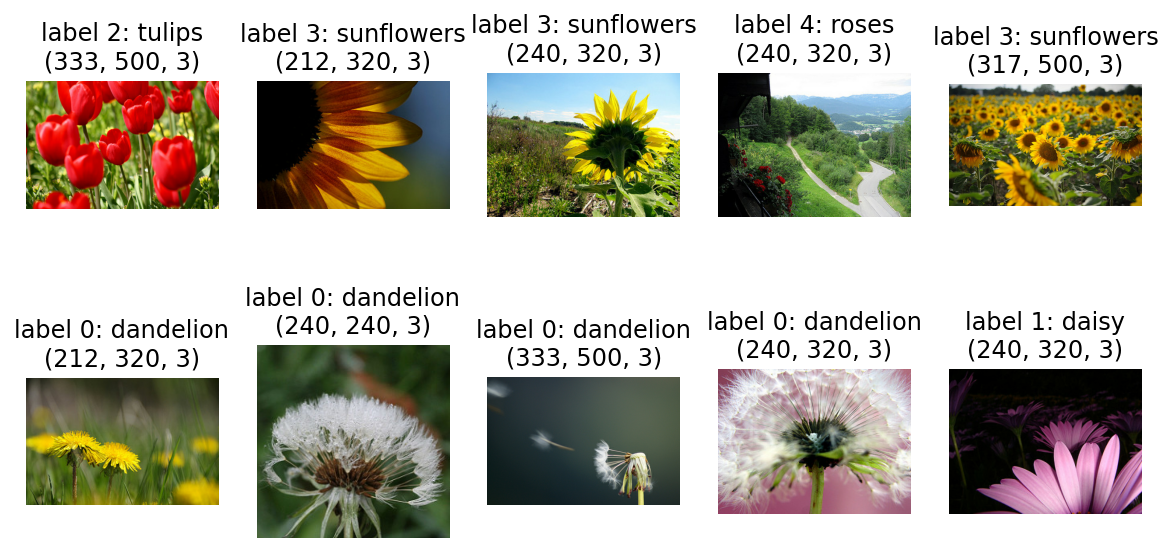

In [7]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    # 이미지 크기 확인을 위해 shape 추가
    image_shape = image.shape
    plt.title(f'label {label}: {get_label_name(label)}\n{image_shape}')
    plt.axis('off')


In [8]:
IMG_SIZE = 224 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


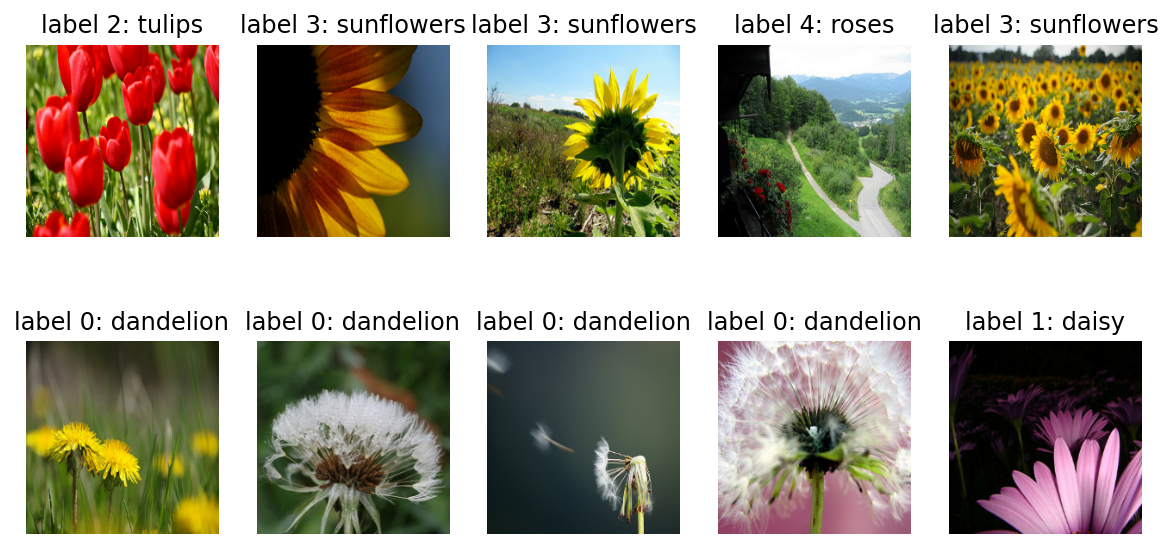

In [10]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [11]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [12]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [13]:
for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32]))

In [14]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG19
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

80150528/80134624 [==============================] - 0s 0us/step


In [15]:
image_batch.shape

TensorShape([32, 224, 224, 3])

In [16]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 7, 7, 512])

In [17]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [19]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [20]:
dense_layer = tf.keras.layers.Dense(units = 512, activation = 'relu')
prediction_layer = tf.keras.layers.Dense(units = 5, activation = 'softmax')

prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(32, 5)


In [21]:
base_model.trainable = False

In [22]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 20,289,605
Trainable params: 265,221
Non-trainable params: 20,024,384
_________________________________________________________________


In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [25]:
EPOCHS = 30
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/30
92/92 [==============================] - 33s 266ms/step - loss: 1.3511 - accuracy: 0.5381 - val_loss: 1.1681 - val_accuracy: 0.6757
Epoch 2/30
92/92 [==============================] - 16s 168ms/step - loss: 1.0540 - accuracy: 0.6962 - val_loss: 0.9541 - val_accuracy: 0.7330
Epoch 3/30
92/92 [==============================] - 16s 170ms/step - loss: 0.8840 - accuracy: 0.7306 - val_loss: 0.8256 - val_accuracy: 0.7520
Epoch 4/30
92/92 [==============================] - 17s 172ms/step - loss: 0.7844 - accuracy: 0.7514 - val_loss: 0.7434 - val_accuracy: 0.7548
Epoch 5/30
92/92 [==============================] - 16s 172ms/step - loss: 0.7201 - accuracy: 0.7670 - val_loss: 0.7154 - val_accuracy: 0.7684
Epoch 6/30
92/92 [==============================] - 17s 177ms/step - loss: 0.6712 - accuracy: 0.7810 - val_loss: 0.6729 - val_accuracy: 0.7711
Epoch 7/30
92/92 [==============================] - 17s 177ms/step - loss: 0.6343 - accuracy: 0.7902 - val_loss: 0.6456 - val_accuracy: 0.7738

In [26]:
test_loss, test_accuracy = model.evaluate(test_batches)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

12/12 [==============================] - 2s 141ms/step - loss: 0.4308 - accuracy: 0.8529
Test Loss: 0.4308
Test Accuracy: 0.8529


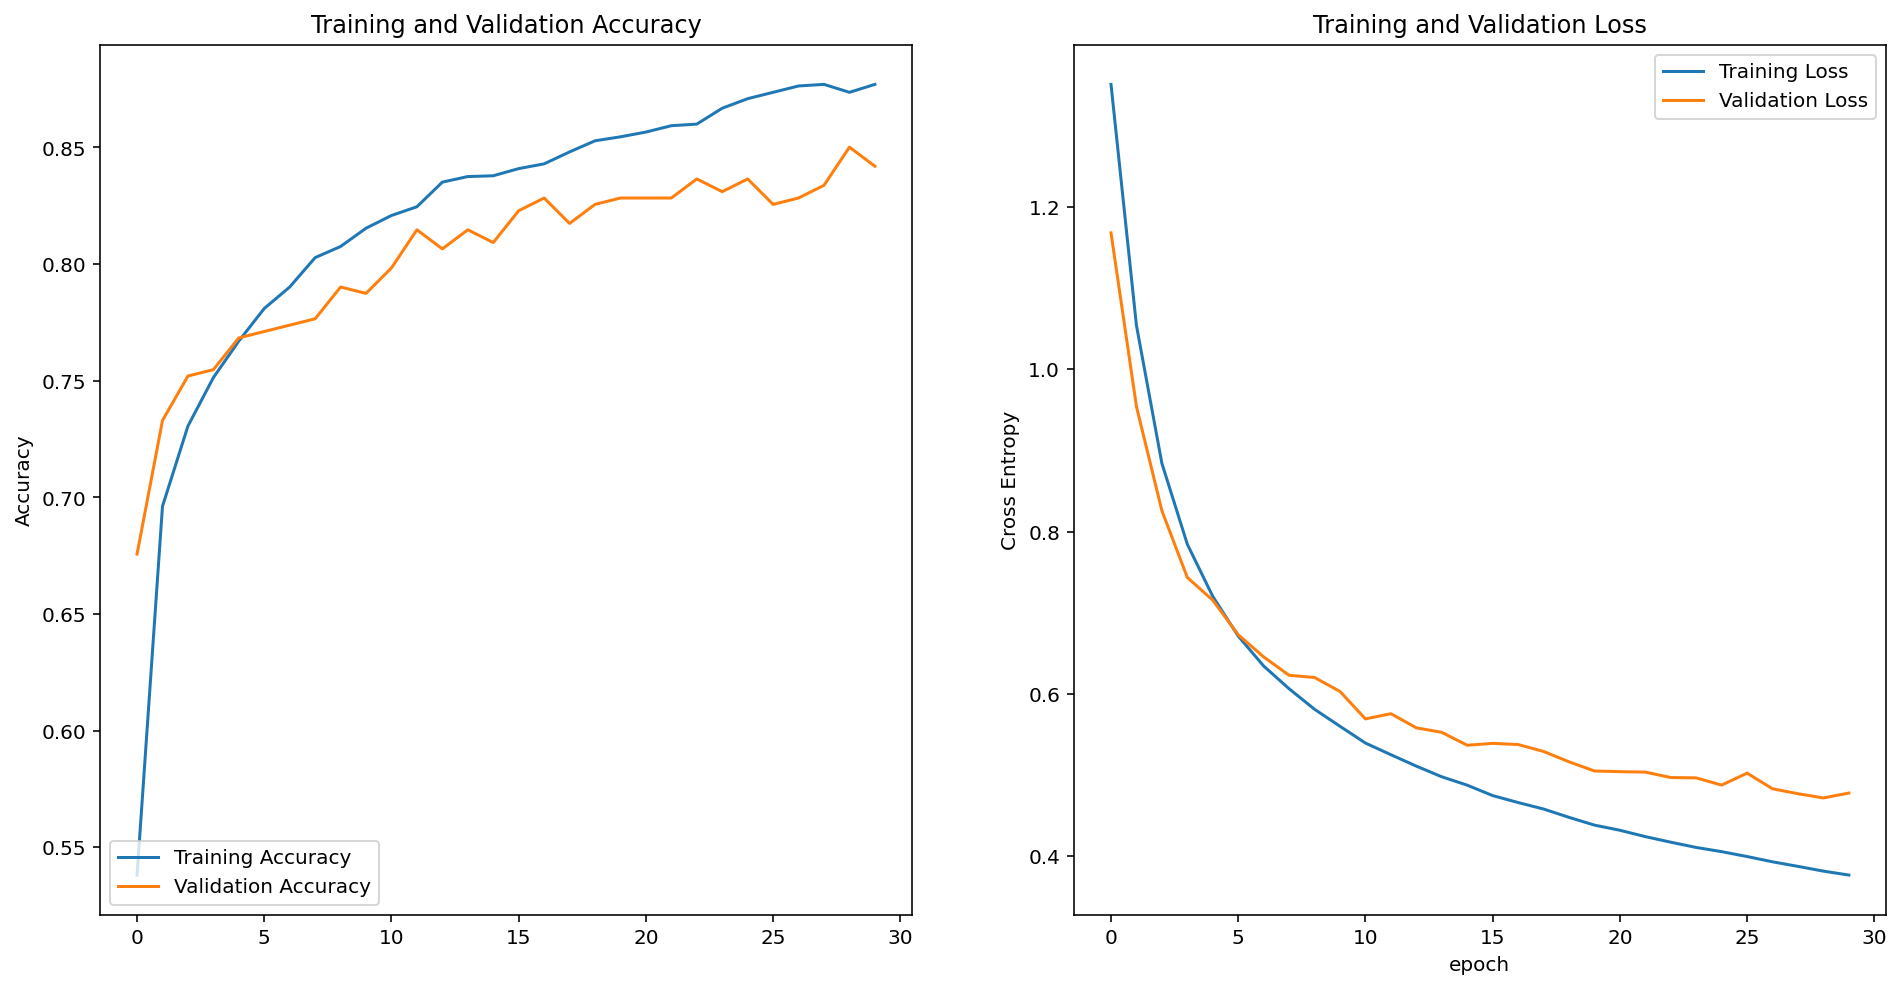

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower left')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

In [33]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 3, 1, 3, 0, 0, 1, 3, 2, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 2, 4, 4, 3, 0, 4])

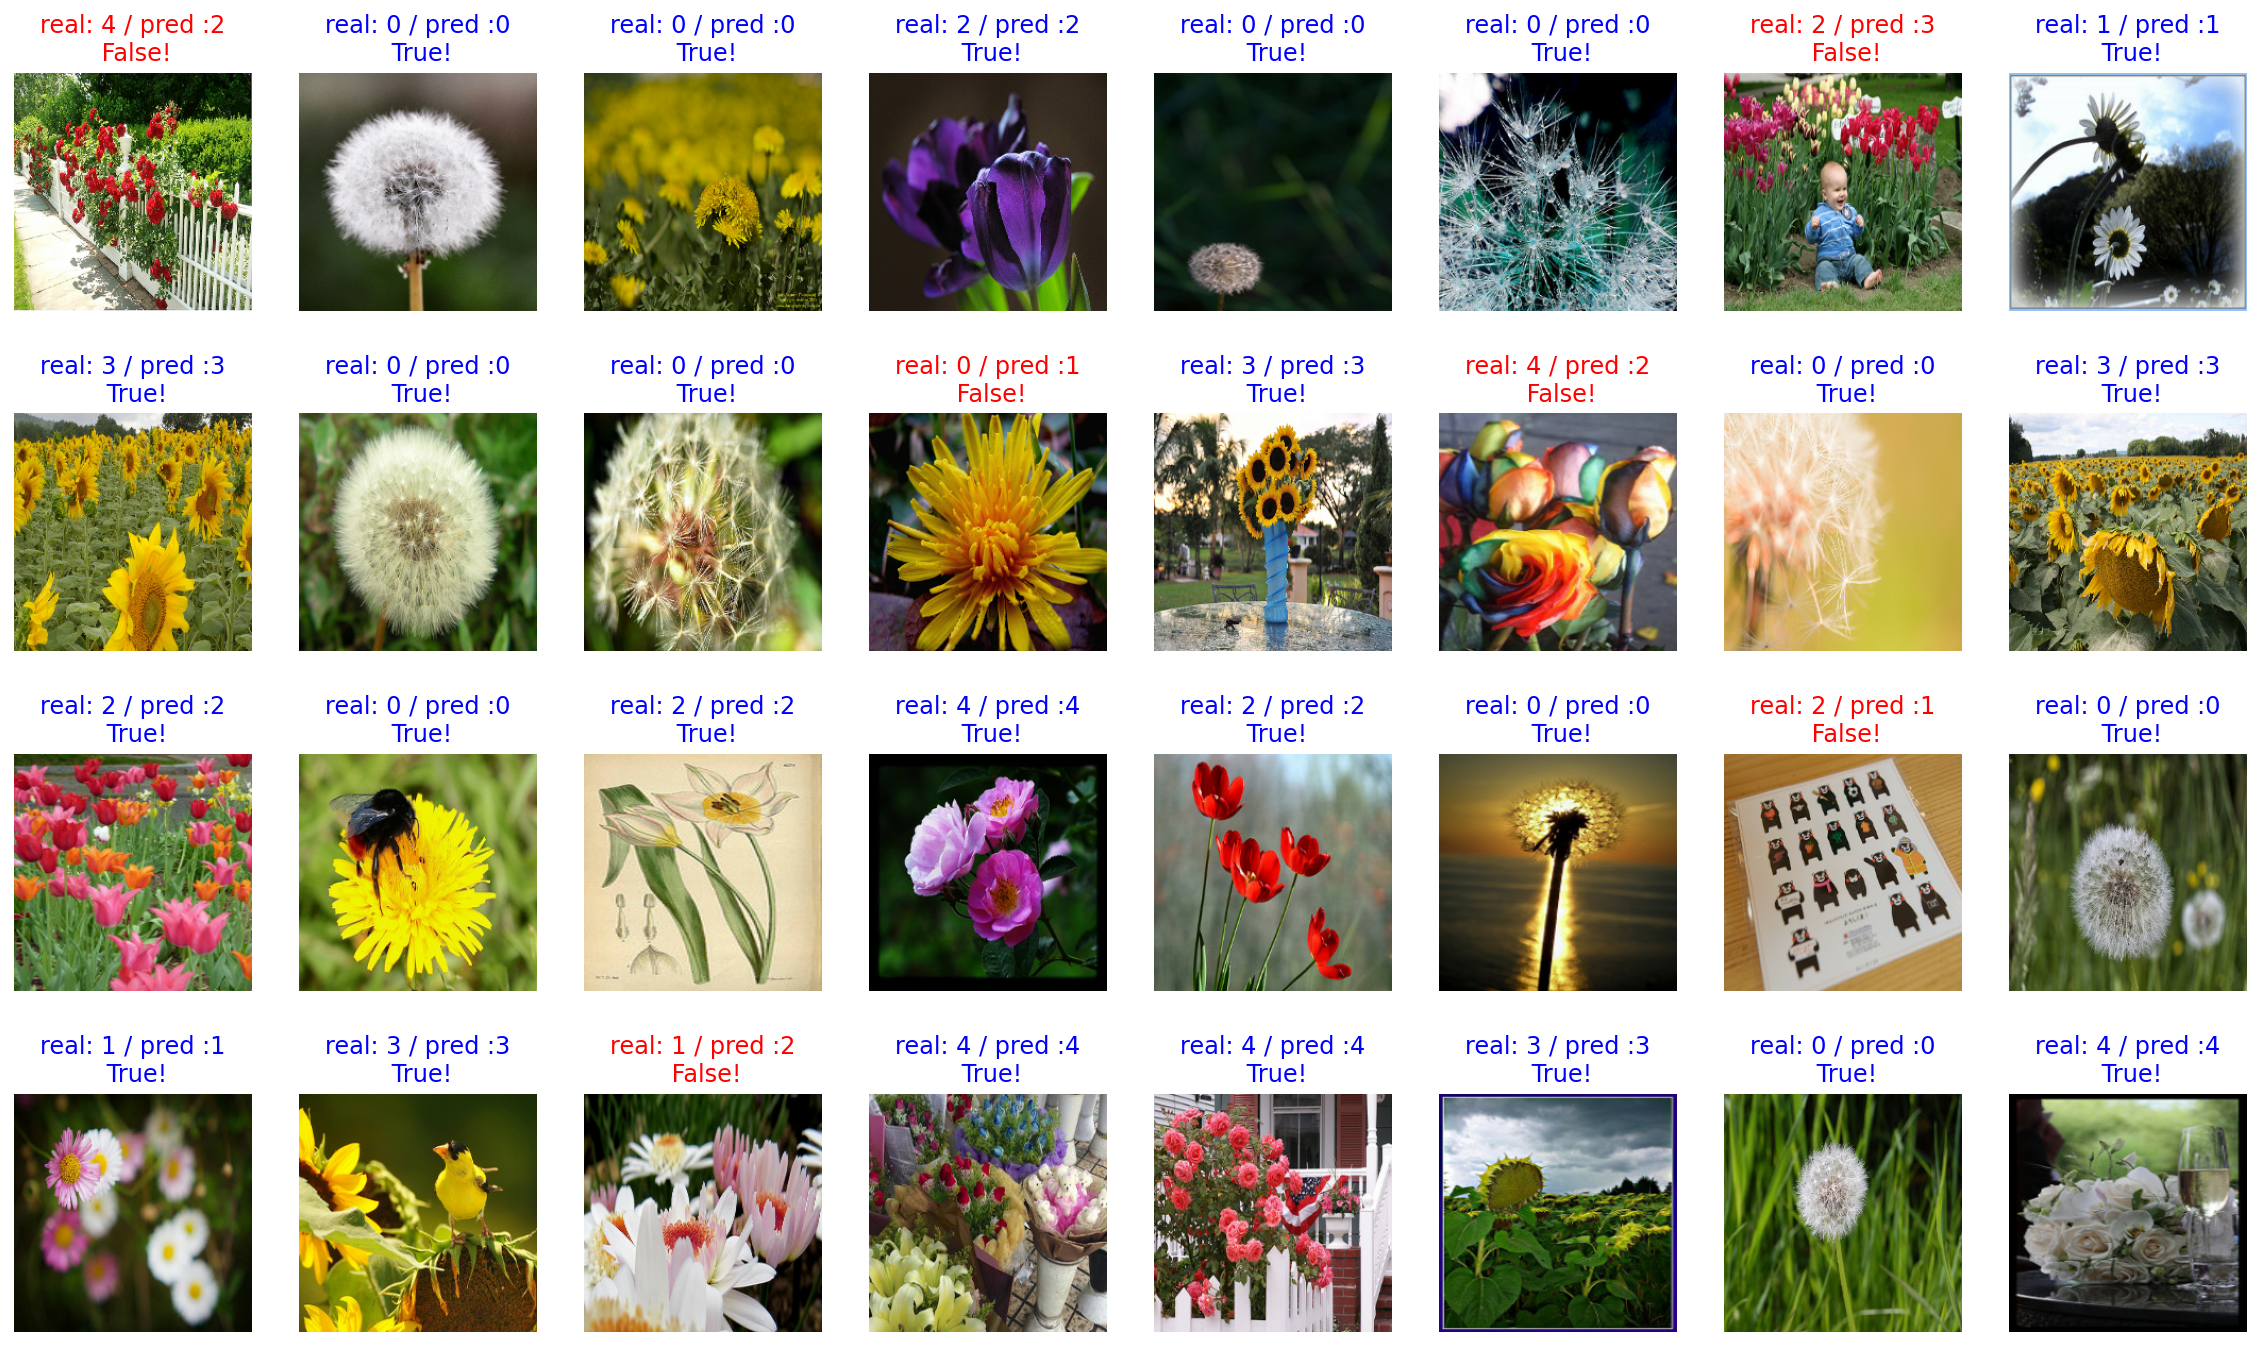

In [34]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [35]:
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [36]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [37]:
# Layers with Batch Normalization and Dropout
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.Sequential([
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.BatchNormalization(),  # 배치 정규화
    tf.keras.layers.Dropout(rate=0.5)      # 드롭아웃 (50%)
])
prediction_layer = tf.keras.layers.Dense(units=5, activation='softmax')


In [38]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512)               264704    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565      
Total params: 20,291,653
Trainable params: 20,290,629
Non-trainable params: 1,024
_________________________________________________________________


In [40]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
EPOCHS = 20
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/20
92/92 [==============================] - 60s 530ms/step - loss: 1.5874 - accuracy: 0.3624 - val_loss: 16.9141 - val_accuracy: 0.1689
Epoch 2/20
92/92 [==============================] - 47s 507ms/step - loss: 1.4204 - accuracy: 0.4131 - val_loss: 4.2752 - val_accuracy: 0.2997
Epoch 3/20
92/92 [==============================] - 48s 513ms/step - loss: 1.2401 - accuracy: 0.4693 - val_loss: 2.9205 - val_accuracy: 0.3270
Epoch 4/20
92/92 [==============================] - 49s 522ms/step - loss: 1.1178 - accuracy: 0.5276 - val_loss: 3.3638 - val_accuracy: 0.2970
Epoch 5/20
92/92 [==============================] - 49s 527ms/step - loss: 0.9367 - accuracy: 0.6012 - val_loss: 3.3159 - val_accuracy: 0.4196
Epoch 6/20
92/92 [==============================] - 48s 513ms/step - loss: 0.8662 - accuracy: 0.6471 - val_loss: 1.0233 - val_accuracy: 0.5967
Epoch 7/20
92/92 [==============================] - 49s 522ms/step - loss: 0.8763 - accuracy: 0.6410 - val_loss: 6.8989 - val_accuracy: 0.348

In [35]:
test_loss, test_accuracy = model.evaluate(test_batches)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

12/12 [==============================] - 2s 140ms/step - loss: 0.9550 - accuracy: 0.7166
Test Loss: 0.9550
Test Accuracy: 0.7166


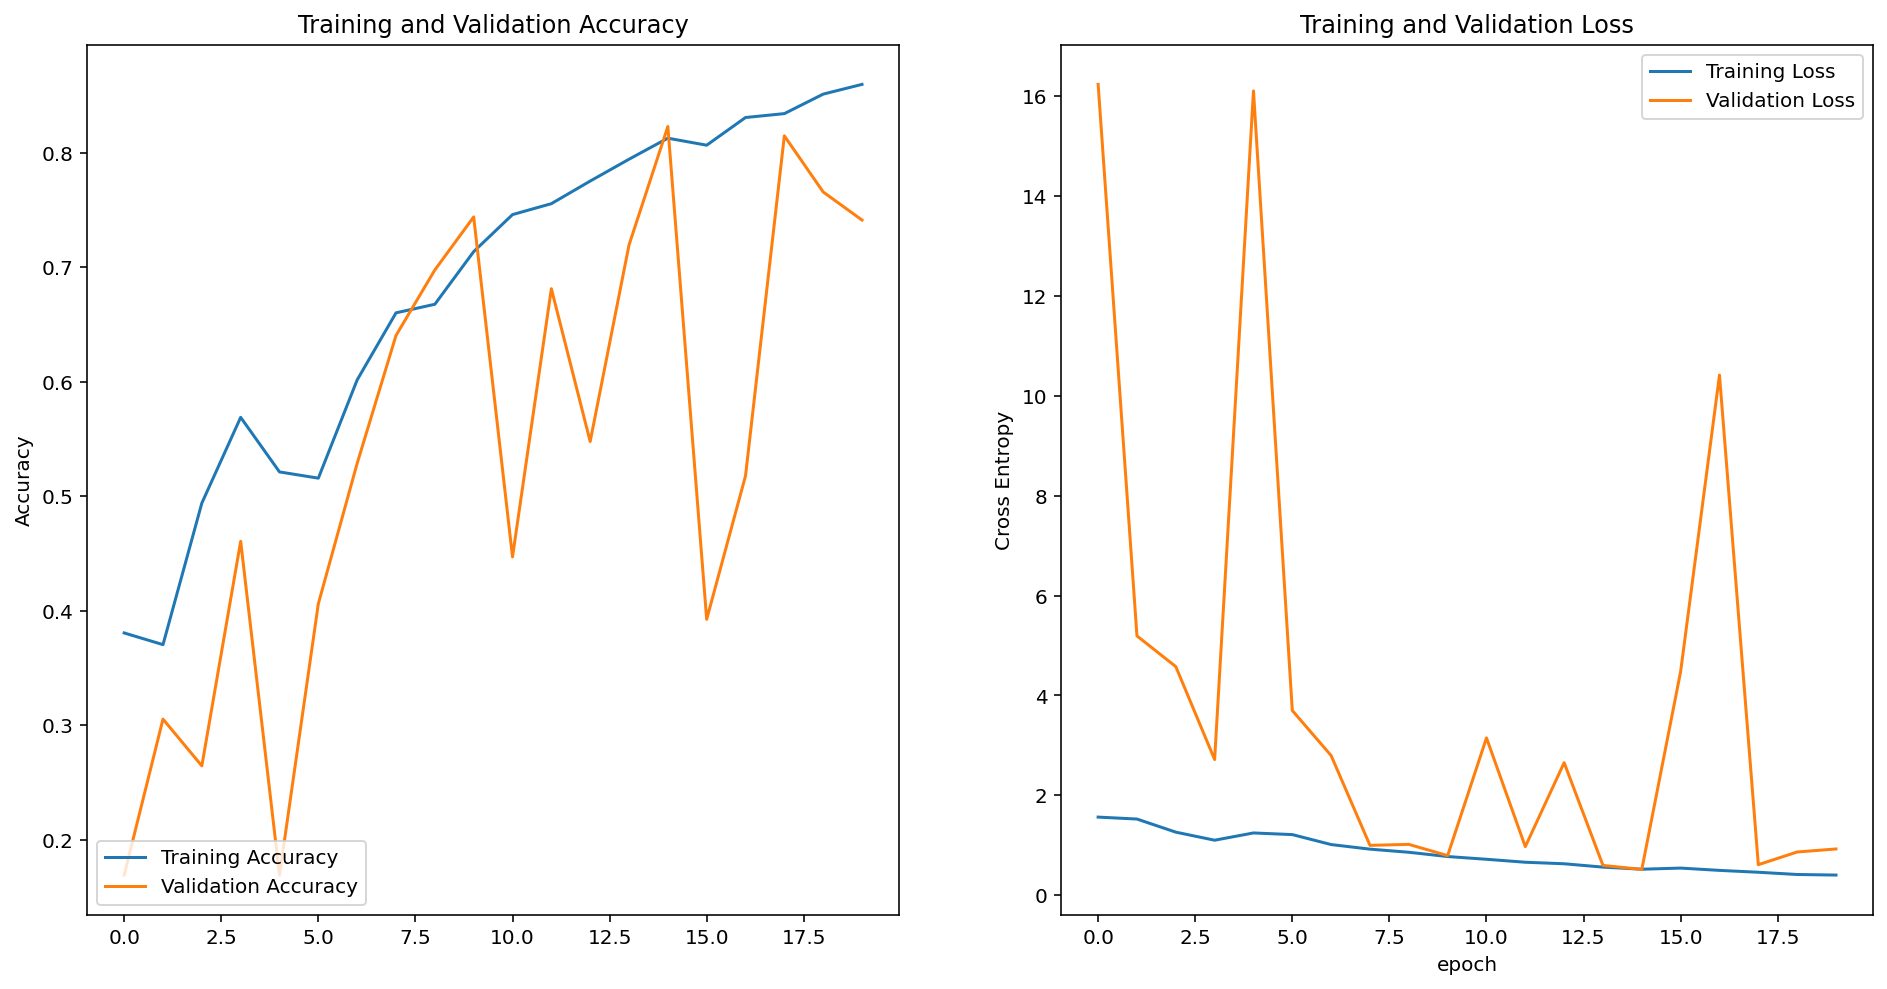

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower left')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [52]:
# 이번엔 efficientNetB0를 다시 도전
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras import layers, models

IMG_SIZE = (160, 160)
BATCH_SIZE = 32

# 데이터 증강
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

# 데이터 전처리 함수
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)  # 크기 조정
    image = data_augmentation(image)  # 데이터 증강
    image = preprocess_input(image)  # EfficientNet 전처리
    label = tf.cast(label, tf.float32)  # 레이블을 float으로 변환
    return image, label

# 데이터셋 준비
train_B0 = raw_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_B0 = raw_validation.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_B0 = raw_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [53]:
# EfficientNetB0 모델 로드
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(160, 160, 3))
base_model.trainable = True  # Feature Extraction 단계에서는 가중치를 고정

In [54]:

# 모델 구성
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')  # 클래스 수에 따라 출력 조정
])

In [55]:

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [56]:

# 학습
EPOCHS = 10
history = model.fit(
    train_B0,
    validation_data=validation_B0,
    epochs=EPOCHS
)

Epoch 1/10
92/92 [==============================] - 35s 304ms/step - loss: 0.6454 - accuracy: 0.7687 - val_loss: 0.6187 - val_accuracy: 0.8311
Epoch 2/10
92/92 [==============================] - 27s 292ms/step - loss: 0.3778 - accuracy: 0.8682 - val_loss: 0.4754 - val_accuracy: 0.8719
Epoch 3/10
92/92 [==============================] - 27s 291ms/step - loss: 0.3032 - accuracy: 0.8910 - val_loss: 0.4795 - val_accuracy: 0.8883
Epoch 4/10
92/92 [==============================] - 27s 293ms/step - loss: 0.2444 - accuracy: 0.9179 - val_loss: 0.5116 - val_accuracy: 0.8556
Epoch 5/10
92/92 [==============================] - 27s 294ms/step - loss: 0.2272 - accuracy: 0.9183 - val_loss: 0.3618 - val_accuracy: 0.8828
Epoch 6/10
92/92 [==============================] - 27s 295ms/step - loss: 0.2244 - accuracy: 0.9278 - val_loss: 0.5598 - val_accuracy: 0.8638
Epoch 7/10
92/92 [==============================] - 27s 292ms/step - loss: 0.1535 - accuracy: 0.9435 - val_loss: 0.3736 - val_accuracy: 0.9074

In [57]:

# 테스트 정확도 확인
test_loss, test_accuracy = model.evaluate(test_B0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


12/12 [==============================] - 2s 172ms/step - loss: 0.3991 - accuracy: 0.8883
Test Loss: 0.3991
Test Accuracy: 0.8883


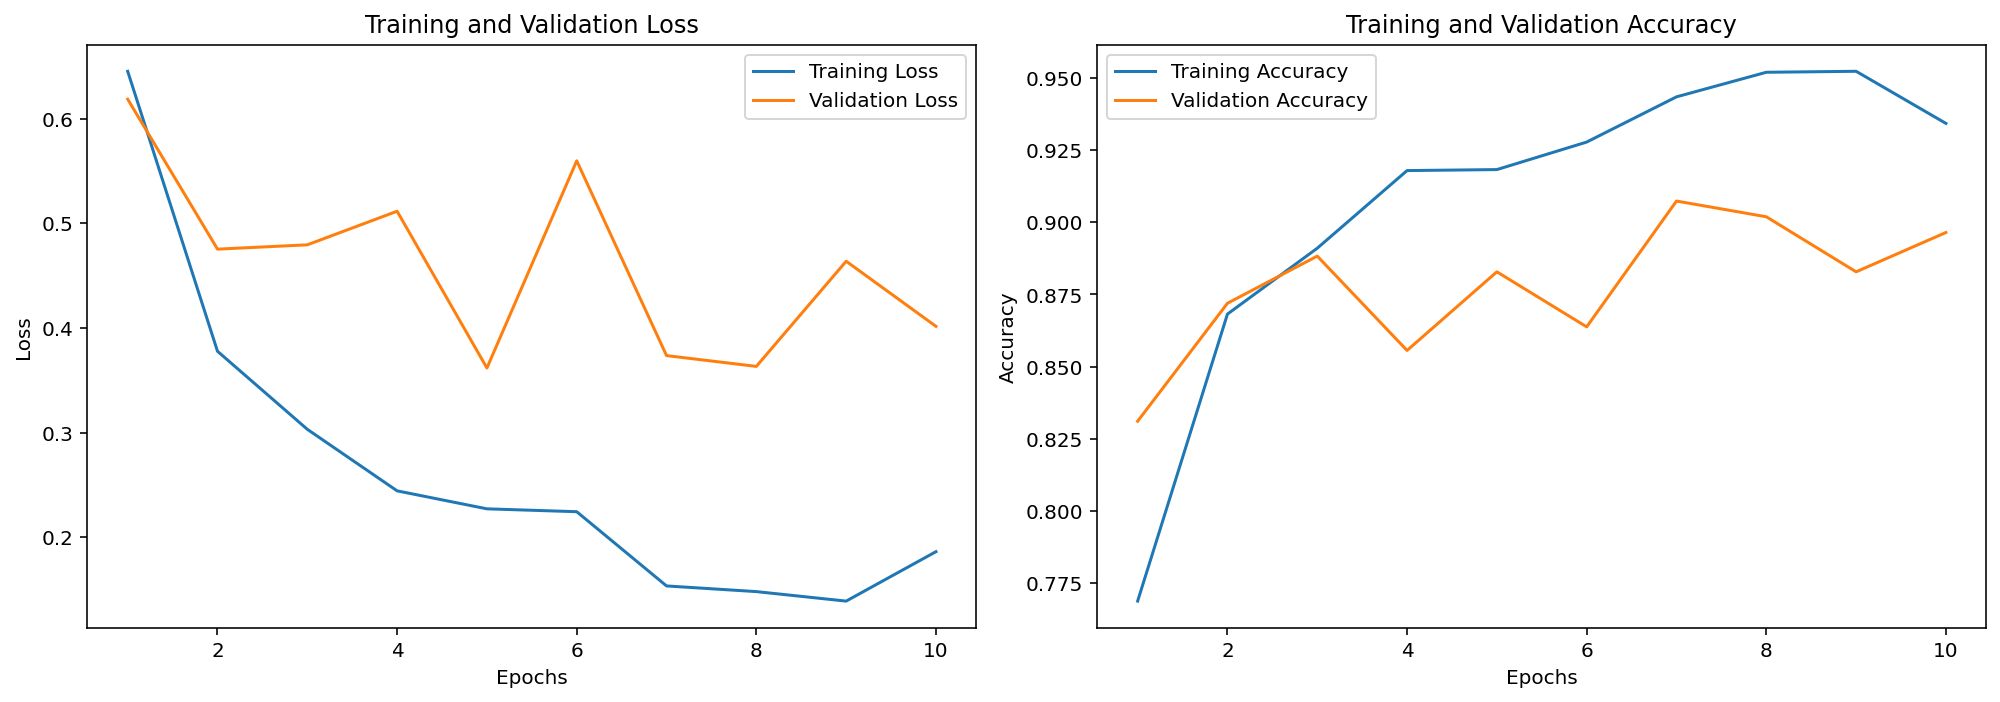

In [58]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # 학습 및 검증 데이터의 loss와 accuracy 시각화
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Loss 그래프
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 모델 학습 후 시각화
plot_training_history(history)


In [59]:
model.save('tf_flower.h5')  # 현재 작업 디렉토리에 'model.h5' 파일로 저장

In [60]:
# 기존 모델을 .tflite 파일로 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# 변환된 모델 저장
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("TensorFlow Lite 모델이 'model.tflite'로 저장되었습니다.")

INFO:tensorflow:Assets written to: /tmp/tmp_i0wnxjo/assets


INFO:tensorflow:Assets written to: /tmp/tmp_i0wnxjo/assets


TensorFlow Lite 모델이 'model.tflite'로 저장되었습니다.
